In [1]:
%load_ext autoreload
%autoreload 2

# standard
import sys
import os

# env specific
import numpy as np
import scipy.linalg as linalg
import cv2

import matplotlib.pyplot as plt
from matplotlib import rcParams

# custom
sys.path.append('e:\\Dropbox\\py_projects\\signal\\signal')
# print(sys.path)
import src.signallib as sl

In [13]:
titlefont = 'Gill Sans MT'
mainfont = 'Arial'
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = [mainfont, titlefont]

rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor'] = 'white'
rcParams['axes.titlesize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

## Data Partition
---

The data for this analysis are the cropped images from [The Extended Yale Face Database B](http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html).

The data is split into a train, validation, and test sets. In this dataset, there are multiple lighting conditions and poses for 38 human subjects. 

The train/valid/test sets all contain images from every subject. Which images of a given subject are randomized into the train/valid/test sets. 

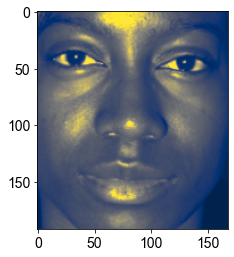

In [5]:
face = 'yaleB22'
image_filepath = f'E:/CroppedYale/{face}/'
image_filename = f'{face}_P00_Ambient.pgm'
image_filename = f'{face}_P00A+005E-10.pgm'

img_test = cv2.imread( image_filepath+image_filename, -1)

plt.imshow(img_test, cmap='cividis')

In [4]:
type(img_test[1,1])

numpy.uint8

In [6]:
image_filepath = f'E:/CroppedYale/'
# each folder contains images for one model
image_keys = [ s[-2:] for s in os.listdir(image_filepath) ]
# all folders have this prefix
image_key_filepath_prefix = 'yaleB'

# init RNG
rng = np.random.default_rng(seed=7)
# init train, valid, test file names lists
train_fns = {}
valid_fns = {}
test_fns = {}
# how many images in validation and test sets per model
nvalid_per_key = 2
ntest_per_key = 1

# create lists of filenames for each set
for k in image_keys:
   # fns in model folder
   fns = os.listdir(image_filepath+image_key_filepath_prefix+k)
   # ambient is sometimes not useful, discard non-PGM files
   fns = [fn for fn in fns if ('.pgm' in fn)
                              & ('Ambient' not in fn)
                              & ('.bad' not in fn)
                              ]
   
   nfns = len(fns)
   # shuffle the image names
   fns_permute = rng.choice(nfns, nfns, replace=False)

   # select image names for each data set
   train_fns[k] = [ image_key_filepath_prefix + k + '/' + fns[i] 
                  for i 
                  in fns_permute[:-(nvalid_per_key+ntest_per_key)]
               ]
   valid_fns[k] = [ image_key_filepath_prefix + k + '/' + fns[i] 
                  for i
                  in fns_permute[-(nvalid_per_key+ntest_per_key):-ntest_per_key] 
               ]
   test_fns[k] = [ image_key_filepath_prefix + k + '/' + fns[i] 
                  for i 
                  in fns_permute[-ntest_per_key:]
               ]
    

## Load and Reshape Training Data
---

1. Load each image in the training set. 
2. Reshape the 2D images into a column vector. 
3. Subtract the average image of the training set from the image.


In [10]:
def load_img_vector( filepath, meanvec=None ):
    img = cv2.imread( filepath, flags=cv2.IMREAD_GRAYSCALE)
    imgvec = np.reshape(img, (-1, ))
    if meanvec is not None:
        imgvec = imgvec - meanvec
    return imgvec

# base path to images
image_filepath = f'E:/CroppedYale/'

# rows and columns of the images
NROWS = 192
NCOLS = 168
# number of training images
NTRAIN = sum([len(fns) for key,fns in train_fns.items()])

# init X matrix
train_X = np.zeros([NROWS*NCOLS, NTRAIN], dtype=np.uint8)
i = 0
for key, fns in train_fns.items():
    for fn in fns:
        imgvec = load_img_vector( image_filepath+fn )
        train_X[:,i] = imgvec
        i += 1

train_X_mean = train_X.mean(axis=1, keepdims=True)
train_meanvec = np.reshape(train_X_mean, (-1,)) # reshape
train_X_std = train_X.std(axis=1, keepdims=True)

train_X_meansub = (train_X - train_X_mean) 
train_X_norm = (train_X - train_X_mean) / train_X_std

## SVD
---

Perform SVD on the training set of images. 

In [11]:
# umat, svals, vmat = linalg.svd( train_X, full_matrices=False, check_finite=False)
umat, svals, vmat = linalg.svd( train_X_meansub, full_matrices=False, check_finite=False)
# umat, svals, vmat = linalg.svd( train_X_norm, full_matrices=False, check_finite=False)

Text(0.5, 1.0, 'Singular values of SVD on log-scale ')

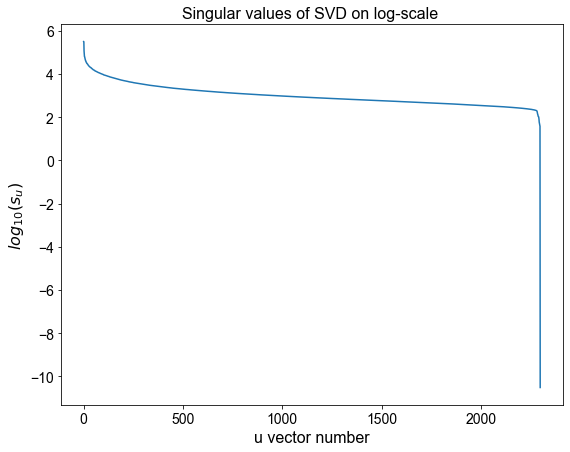

In [18]:
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(np.log10(svals))
ax.set_xlabel('u vector number')
ax.set_ylabel(r'$log_{10}( s_{u} )$')
ax.set_title('Singular values of SVD on log-scale ')


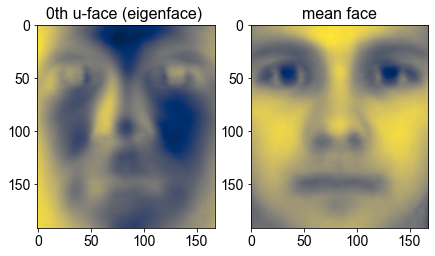

In [19]:
nu = 0
img_uface = np.reshape(umat[:,nu], [NROWS, NCOLS])
img_meanface = np.reshape(train_X_mean, [NROWS, NCOLS])
fig,(ax0,ax1) = plt.subplots(nrows=1,ncols=2, figsize=(7,7))
cmapname = 'cividis'
ax0.imshow(img_uface, cmap=cmapname)
ax1.imshow(img_meanface, cmap=cmapname)
ax0.set_title(f'{nu}th u-face (eigenface) ')
ax1.set_title(f'mean face')
plt.show()

## Project onto u-space
---

1. For each subject, project their images onto the reduced vector space spanned by the first N columns of the U matrix.
2. Compute the average u-space projection for each subject.



In [55]:
# number of SVD vectors in dimension reduced U-space
N_UVEC = 1000
umat_reduced = umat[:, :N_UVEC]

key_projections = {}

for key, fns in train_fns.items():
    # cols are projections of fn onto u-vectors
    uproj = np.zeros([ N_UVEC, len(fns)])

    for i,fn in enumerate(fns):
        imgvec = load_img_vector(image_filepath+fn, meanvec=train_meanvec)
        
        uproj_fn = (np.transpose(umat_reduced) @ imgvec) / svals[:N_UVEC]

        uproj[:,i] = uproj_fn
    
    key_projections[key] = uproj


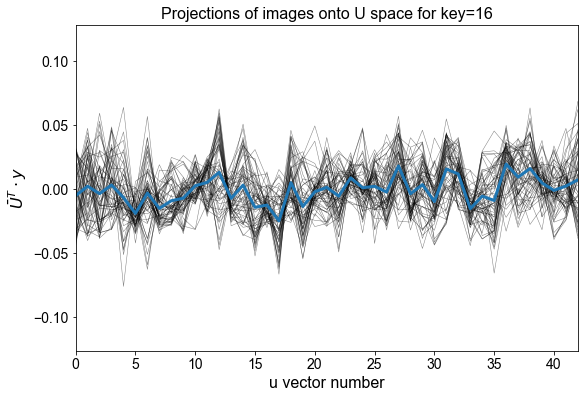

In [56]:
keytemp = '16'
fig,ax = plt.subplots(figsize=(9,6))
nimg = key_projections[keytemp].shape[1]

umean = np.mean(key_projections[keytemp], axis=1)
ax.plot((umean), linewidth=3, zorder=1)
for i in range(nimg):
    # ax.semilogy(np.abs(key_projections[keytemp][:,i]), color='k', linewidth=1.5, zorder=0)
    ax.plot((key_projections[keytemp][:,i]), color='k', linewidth=0.5, alpha=0.5, zorder=0)
ax.set_xlim([0,42])
# ax.set_ylim([-1000,1000])
ax.set_xlabel('u vector number', fontsize=16)
ax.set_ylabel(r'$\bar{U}^T \cdot y$', fontsize=16)
plt.title(f'Projections of images onto U space for key={keytemp}')
plt.show()

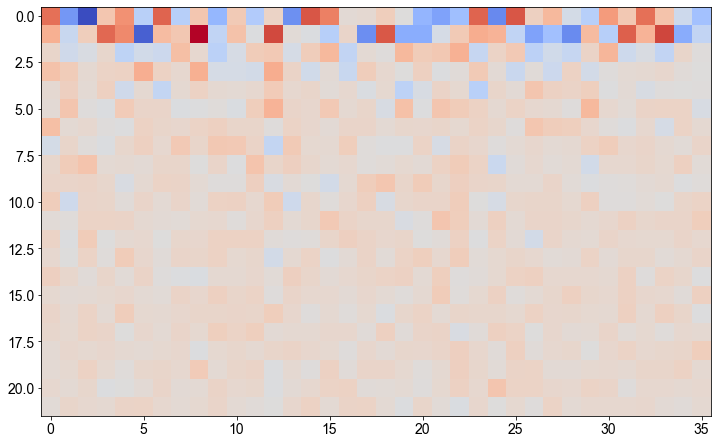

In [48]:
fig,ax = plt.subplots(figsize=(12,12))
train_projection = (np.transpose(umat_reduced) @ train_X_meansub) / svals[N_UVEC]
# plt.imshow(train_projection[:22,:64], aspect=1, cmap='coolwarm', vmin=-1.5e4,vmax=1.5e4)
plt.imshow(train_projection[:22,4::64], aspect=1, cmap='coolwarm')

In [57]:
# average projection of key onto u-space
NKEYS = len(image_keys)
key_projections_u_mean = np.zeros([NKEYS, N_UVEC])
key_projections_u_median = np.zeros([NKEYS, N_UVEC])
for i,(key,proj) in enumerate(key_projections.items()):
    # print(i)
    key_projections_u_mean[i,:] = proj.mean(axis=1)
    key_projections_u_median[i,:] = np.median(proj, axis=1)

    

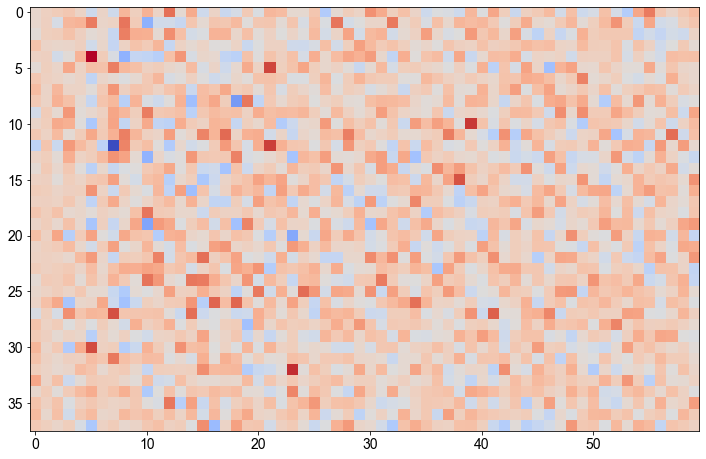

In [24]:
fig,ax = plt.subplots(figsize=(12,12))

plt.imshow(key_projections_u_mean[:,:60] , aspect=1, cmap='coolwarm',  interpolation='none')

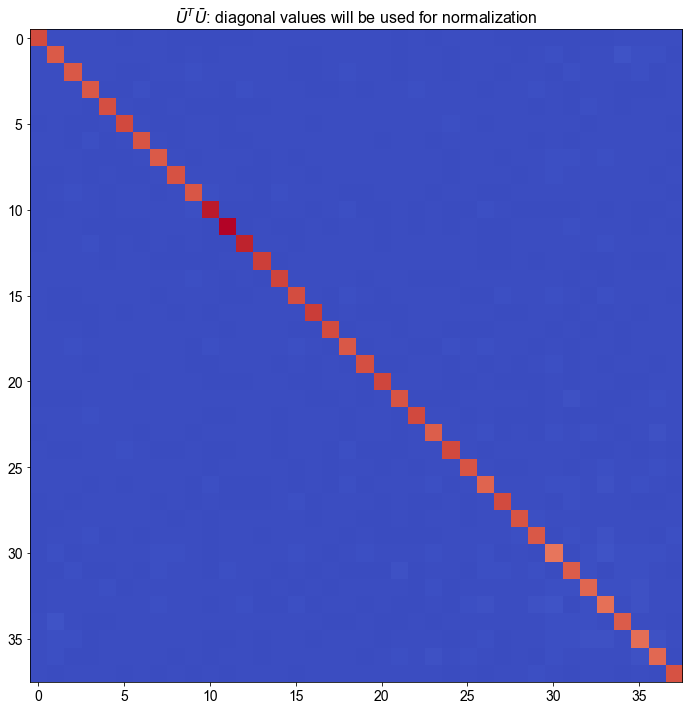

In [58]:
fig,ax = plt.subplots(figsize=(12,12))

plt.imshow(key_projections_u_mean @ np.transpose(key_projections_u_mean) , aspect=1, cmap='coolwarm',  interpolation='none')

plt.title(r'$\bar{U}^T\bar{U}$: diagonal values will be used for normalization')
# plt.imshow(key_projections_u_median @ np.transpose(key_projections_u_median) , aspect=1, cmap='coolwarm',  interpolation='none')
# plt.imshow(np.transpose(key_projections_u_mean[:,:]), aspect=1, cmap='coolwarm', vmin=-5e3,vmax=5e3, interpolation='none')

plt.show()

## Classify Image
---

Attempt to classify an image (which subject is it?) based on its projection on the u-space. 
1. Load image, $\vec{y}$
2. Project onto reduced u-space, $U^T\vec{y}$
   1. Normalized by the singular values of the u vectors 
3. Matrix of average u-space projection, $V$
4. Compute correlation with subject classes: $V U^T\vec{y}$ 




In [26]:
def softmax( zvec ):
    """
    Boltzman distribution for the values of the zvec.
    """
    Z = np.sum(np.exp(zvec))
    return np.exp(zvec) / Z

def img_class_prob( imgvec, umat_reduced, key_project_mean, svals_reduced ):
    '''
    Project the image vector onto the reduced U space and compare to the average projection of the image classes.

    The projection is normalized by the 
    '''
    # normalize by singular value?
    imgvec_proj = (np.transpose(umat_reduced) @ imgvec) / svals_reduced
    normconst_imgvec_proj = np.sqrt(imgvec_proj @ imgvec_proj)
    normconstvec_key_proj = (key_project_mean @ np.transpose(key_project_mean)).diagonal()
    normconstvec_key_proj = np.sqrt(normconstvec_key_proj)
    # print(normconstvec_key_proj)
    imgvec_proj_overlap = (key_project_mean @ imgvec_proj)  / (normconstvec_key_proj * normconst_imgvec_proj)
    imgvec_proj_overlap = imgvec_proj_overlap
    # imgvec_probability = imgvec_proj_overlap
    imgvec_probability = softmax( imgvec_proj_overlap )
    return imgvec_probability



subject 01
highest prob subjects ['34' '09' '15' '07' '37' '20' '01'] 
highest prob [2.63175289 2.6334893  2.63387459 2.63543136 2.63650441 2.64349039
 3.10569114] 
subject 02
highest prob subjects ['09' '18' '25' '33' '04' '35' '02'] 
highest prob [2.64059889 2.64367227 2.64879978 2.65234712 2.66268127 2.68358114
 3.1927819 ] 
subject 03
highest prob subjects ['07' '39' '32' '15' '11' '04' '03'] 
highest prob [2.63428851 2.63710052 2.63836785 2.64008235 2.64154355 2.65497388
 3.25542836] 
subject 04
highest prob subjects ['05' '09' '35' '38' '24' '01' '04'] 
highest prob [2.63357401 2.63387455 2.64004444 2.64031201 2.64069809 2.64549192
 3.23451519] 
subject 05
highest prob subjects ['36' '02' '25' '17' '37' '23' '05'] 
highest prob [2.63442954 2.63484477 2.63507662 2.63667797 2.63859378 2.65182339
 3.09722424] 
subject 06
highest prob subjects ['01' '34' '23' '07' '25' '02' '06'] 
highest prob [2.63228532 2.6330505  2.63766285 2.64131477 2.64377741 2.6448825
 3.2785345 ] 
subject 07


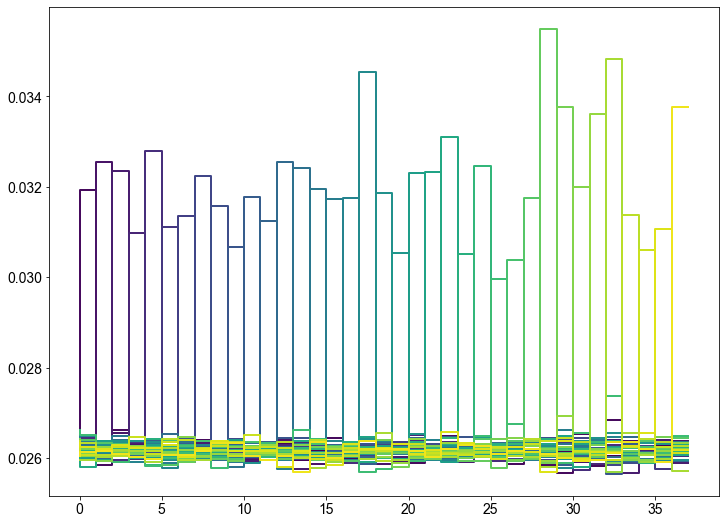

In [59]:
fig, ax = plt.subplots(figsize=(12,9))
from matplotlib import cm
cmap = cm.get_cmap('viridis')
image_keys_np = np.array(image_keys)
for i,keytemp in enumerate(image_keys[:]):
    fnindextemp = 3
    imgvec1 = load_img_vector(image_filepath+train_fns[keytemp][fnindextemp], meanvec=train_meanvec)
    img_prob = img_class_prob( imgvec1, umat_reduced, key_projections_u_mean, svals[:N_UVEC] )
    ls = {'linewidth':2.0, 'marker':'o', 'markersize':0}
    
    ls['color']=cmap((i)/NKEYS)
    ax.step(np.arange(NKEYS),img_prob, **ls)

    print(f'subject {keytemp}')
    ipi = img_prob.argsort()
    print(f'highest prob subjects {image_keys_np[ipi[-7:]]} ')
    print(f'highest prob {100*img_prob[ipi[-7:]]} ')
    # print(img_prob)
    # print(img_prob.sum())

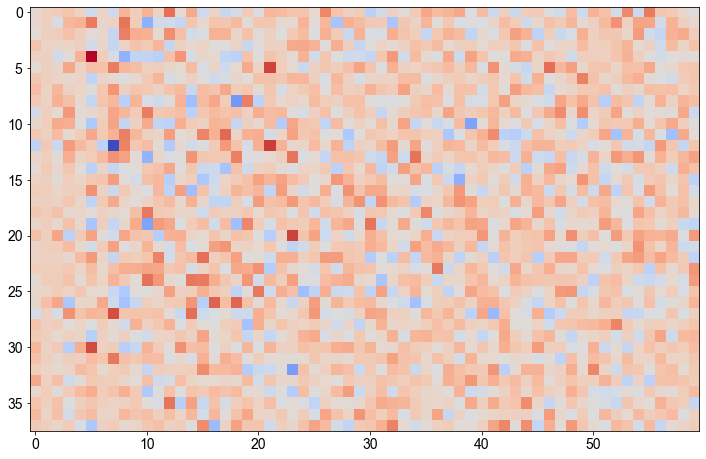

In [578]:
fig,ax = plt.subplots(figsize=(12,12))

plt.imshow(key_projections_u_mean[:,:60] , aspect=1, cmap='coolwarm',  interpolation='none')

In [560]:
key_projections_u_mean.max()

0.04311096220476653

## Classification Error
---

Compute the percentage of correctly classified images.

Increasing the size of the reduced U space improves the classification ability of this SVD based algorithm.

| u-vecs      | error % |
| ----------- | ----------- |
| 100         | 13.1       |
| 500         | 3.95        |
| 1000        | 1.32        |



The success of this SVD classification approach relies on the tight constraints on the data. 
- The images are cropped and positioned in a well defined way. 
- There are many training data points for each class/subject. 
- There are only a few classes, $N_{classes}$, compared to the input information, $N_{pixels}$  
$$N_{classes} \ll N_{pixels} $$
  
These conditions lead to there being a large amount of information about the subject of the image in the vector space spanned by the columns of the reduced/truncated $U$ matrix.




In [52]:
def img_set_classification_error( fnsdict: dict, fnspath: str
                                , meanvec: np.ndarray
                                , umat_reduced: np.ndarray
                                , key_projections_u_mean: np.ndarray
                                , svals_reduced: np.ndarray
                                 ):
    keylist = list(fnsdict.keys())
    key_error_dict = {key:[] for key in keylist}
    key_probability_dict = {key:[] for key in keylist}

    key_predict_correct = 0
    total_fns = 0
    for i,(key,fns) in enumerate(fnsdict.items()):

        for fn in fns:
            total_fns += 1
            # compute class probability for each image file
            imgvec = load_img_vector( fnspath+fn, meanvec )
            imgvec_prob = img_class_prob( imgvec, umat_reduced, key_projections_u_mean, svals_reduced )

            key_predict_probability = imgvec_prob.max()
            key_probability_dict[key].append(key_predict_probability)

            key_predict = keylist[imgvec_prob.argmax()]
            if key_predict == key:
                key_error_dict[key].append(0)
                key_predict_correct += 1
            else:
                key_error_dict[key].append(1)
            
    return key_predict_correct, total_fns, key_error_dict, key_probability_dict



In [60]:
valid_correct, valid_total, valid_key_error_dict, valid_key_probability_dict = img_set_classification_error( valid_fns, image_filepath
                              , train_meanvec
                              , umat_reduced, key_projections_u_mean, svals[:N_UVEC]
                                )

In [63]:
print(f'size of reduced u-space = {N_UVEC:d}')
print(f'correctly classified {(100*valid_correct / valid_total):0.2f}%')
print(f'classification error {100*(1 - valid_correct / valid_total):0.2f}%')

size of reduced u-space = 1000
correctly classified 98.68%
classification error 1.32%


In [31]:
valid_key_error_dict

{'01': [0, 0],
 '02': [0, 1],
 '03': [0, 0],
 '04': [0, 0],
 '05': [0, 0],
 '06': [0, 0],
 '07': [0, 0],
 '08': [0, 0],
 '09': [0, 0],
 '10': [0, 0],
 '11': [0, 0],
 '12': [0, 0],
 '13': [0, 0],
 '15': [0, 0],
 '16': [0, 0],
 '17': [0, 0],
 '18': [0, 0],
 '19': [0, 0],
 '20': [0, 0],
 '21': [0, 1],
 '22': [0, 0],
 '23': [0, 0],
 '24': [0, 0],
 '25': [0, 0],
 '26': [0, 0],
 '27': [0, 0],
 '28': [0, 0],
 '29': [0, 0],
 '30': [0, 0],
 '31': [0, 0],
 '32': [0, 0],
 '33': [0, 0],
 '34': [0, 0],
 '35': [0, 0],
 '36': [0, 0],
 '37': [0, 0],
 '38': [0, 0],
 '39': [0, 0]}